# PJM Energy Consumption Forecasting and Deployment with Streamlit

## Step 1: Import Required Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

## Step 2: Load and Preprocess PJM Data

In [7]:
# Load dataset
df = pd.read_csv("PJMW_hourly.csv")

# Convert to datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set Datetime as index
df.set_index('Datetime', inplace=True)

# Sort index
df.sort_index(inplace=True)

# Drop duplicates
df = df[~df.index.duplicated(keep='first')]

# Resample to hourly frequency
df = df.asfreq('H')

# Visual check
print(df.head())


                     PJMW_MW
Datetime                    
2002-04-01 01:00:00   4374.0
2002-04-01 02:00:00   4306.0
2002-04-01 03:00:00   4322.0
2002-04-01 04:00:00   4359.0
2002-04-01 05:00:00   4436.0


C:\Users\mukes\AppData\Local\Temp\ipykernel_26876\1266663433.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq('H')


## Step 3: Train-Test Split

In [9]:
# Option 1: Forward fill
df_ffill = df.fillna(method='ffill')

# Option 2: Time-based interpolation
df_interp = df.interpolate(method='time')

# Use interpolated for further steps
df = df_interp


C:\Users\mukes\AppData\Local\Temp\ipykernel_26876\2057915390.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ffill = df.fillna(method='ffill')


In [19]:
df

,PJMW_MW
Datetime,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0
...,...
2018-08-02 20:00:00,6545.0
2018-08-02 21:00:00,6496.0
2018-08-02 22:00:00,6325.0


In [11]:
# Confirm frequency and types
print("Index freq:", pd.infer_freq(df.index))
print(df.dtypes)

# Check for nulls again
print(df.isnull().sum())

# Check for duplicates
print("Duplicates:", df.duplicated().sum())
df

Index freq: h
PJMW_MW    float64
dtype: object
PJMW_MW    0
dtype: int64
Duplicates: 137871


,PJMW_MW
Datetime,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0
...,...
2018-08-02 20:00:00,6545.0
2018-08-02 21:00:00,6496.0
2018-08-02 22:00:00,6325.0


In [27]:
# Remove duplicated rows
# df = df[~df.index.duplicated(keep='first')]

# Optional: reset index if needed
df = df.reset_index().drop_duplicates().set_index('Datetime')
df


,PJMW_MW
Datetime,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0
...,...
2018-08-02 20:00:00,6545.0
2018-08-02 21:00:00,6496.0
2018-08-02 22:00:00,6325.0


In [31]:
df = df[~df.index.duplicated(keep='first')]
df

,PJMW_MW
Datetime,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0
...,...
2018-08-02 20:00:00,6545.0
2018-08-02 21:00:00,6496.0
2018-08-02 22:00:00,6325.0


In [33]:
from scipy.stats import zscore

# Calculate z-scores
z_scores = zscore(df['PJMW_MW'])
outliers = np.where(np.abs(z_scores) > 3)
print(f"Outliers detected: {len(outliers[0])}")


Outliers detected: 298


In [35]:
from scipy import stats
import numpy as np

# Detect outliers using z-score method
z_scores = np.abs(stats.zscore(df['PJMW_MW']))
df['is_outlier'] = z_scores > 3

# Replace outliers with NaN
df.loc[df['is_outlier'], 'PJMW_MW'] = np.nan

# Interpolate to fill the outliers (treated as missing)
df['PJMW_MW'] = df['PJMW_MW'].interpolate(method='time')

# Drop the helper column
df.drop(columns='is_outlier', inplace=True)


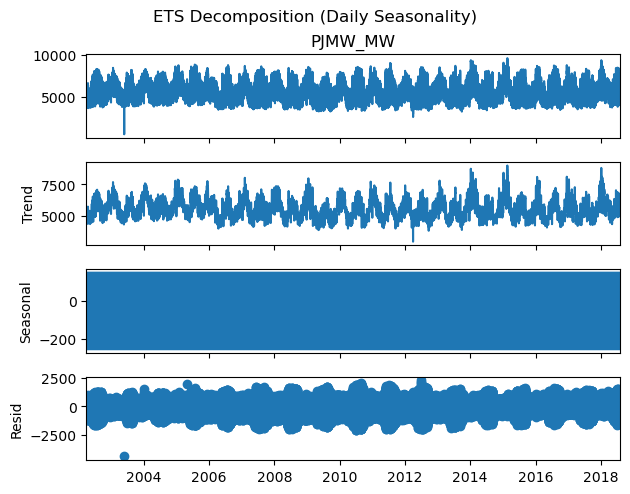

In [67]:
result = seasonal_decompose(df['PJMW_MW'], model='additive', period=24)
result.plot()
plt.suptitle("ETS Decomposition (Daily Seasonality)", y=1.02)
plt.show()


In [41]:
# Ensure datetime index is sorted
df = df.sort_index()

# Split the last year as test set
train = df.loc[:'2021-12-31']
test = df.loc['2022-01-01':]


In [43]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit model on train data
model = ExponentialSmoothing(
    train['PJMW_MW'],
    trend='add',
    seasonal='add',
    seasonal_periods=24
).fit()


C:\Users\mukes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\mukes\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\mukes\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [51]:
import pandas as pd

# Load the data
df = pd.read_csv("PJMW_hourly.csv", parse_dates=['Datetime'], index_col='Datetime')

# Sort by datetime just in case
df = df.sort_index()

# Fill missing values if any
df = df.interpolate(method='time')

# Drop duplicates
df = df[~df.index.duplicated(keep='first')]


In [53]:
data = df['PJMW_MW'].reset_index(drop=True)


In [57]:
test_size = 8760
train = data[:-test_size]
test = data[-test_size:]


In [59]:
# Forecast same number of points as test
forecast = model.forecast(steps=len(test))

# Align the forecast index with test index
forecast.index = test.index


In [61]:
forecast = model.forecast(len(test))


In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 821.04
RMSE: 1032.62


In [69]:
import pickle

with open("hw_model.pkl", "wb") as f:
    pickle.dump(model, f)
